Hotel Booking Demand

Importing Data Libraries.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pycountry

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pycountry as pc

     |████████████████████████████████| 10.1 MB 22.4 MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746883 sha256=a9463c6b2a159c1e6453baf23bcf57fa8f4911c3657961530b477ac2eadca24b
  Stored in directory: /root/.cache/pip/wheels/57/e8/3f/120ccc1ff7541c108bc5d656e2a14c39da0d824653b62284c6
Successfully built pycountry


In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/train.csv',index_col=0)

In [5]:
train_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
Transaction_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1002,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1003,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
1004,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
1005,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# **Data Cleaning**

In [6]:
train_copy = train_data.copy()
train_copy.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,99996.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,85565.000000,5923.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.442070,106.339730,2016.03237,27.630900,15.728930,0.94293,2.55361,1.855180,0.102164,0.008260,0.035490,0.103800,0.160390,0.207940,97.376416,179.686645,2.754230,99.478089,0.068790,0.516830
std,0.496635,108.218604,0.68646,13.401401,8.764458,1.02108,1.98035,0.587716,0.396599,0.100359,0.185016,0.921528,1.632382,0.629464,114.289032,129.212578,19.155146,51.674414,0.256434,0.762222
min,0.000000,0.000000,2015.00000,1.000000,1.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.00000,17.000000,8.000000,0.00000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,51.000000,0.000000,65.000000,0.000000,0.000000
50%,0.000000,71.000000,2016.00000,28.000000,16.000000,1.00000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,174.000000,0.000000,90.065000,0.000000,0.000000
75%,1.000000,165.000000,2017.00000,39.000000,23.000000,2.00000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,240.000000,251.000000,0.000000,123.000000,0.000000,1.000000
max,1.000000,737.000000,2017.00000,53.000000,31.000000,19.00000,50.00000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


1. **Missing Values**

In [7]:
train_copy.isnull().sum().sort_values(ascending=False)[:5]

company      94077
agent        14435
country        487
children         4
lead_time        0
dtype: int64

The company and agent corresponds to the respective IDs (may be a foriegn key). Hence, we can replace the missing values with 0 indicating the record has no agent or company involved

In [8]:
train_copy['company'].fillna(0, inplace=True)
train_copy['agent'].fillna(0, inplace=True)

In [9]:
train_copy['country'].value_counts()

PRT    45875
GBR    10040
ESP     7333
FRA     7179
DEU     4974
       ...  
NPL        1
PLW        1
ATA        1
MMR        1
GUY        1
Name: country, Length: 168, dtype: int64

The most repeating attribute of the feature is PRT (Portugal) and it can be a good measure of central tendancy due to the number of observations, hence we can replace the missing values with the mode.

In [10]:
train_copy['country'].fillna(train_data.country.mode().to_string(), inplace=True)

In [11]:
train_copy['children'].describe()

count    99996.000000
mean         0.102164
std          0.396599
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: children, dtype: float64

For Children, we can use the mean, which would be a good measure of central tendancy, to fill in the missing values.

In [12]:
train_copy['children'].fillna(train_data.children.mean(), inplace=True)

In [13]:
train_copy.isnull().sum().sort_values(ascending=False)[0:30]

reservation_status_date           0
reservation_status                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type               

**Data Type Conversion**

In [14]:
train_copy.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [15]:
train_copy[['children', 'company', 'agent']] = train_copy[['children', 'company', 'agent']].astype('int64')
train_copy.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                            int64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [16]:
train_data = train_copy

# Data Analysis

** **bold text**Utility Functions**

In [17]:
def getCount(series):
    '''
       Takes in a series as input and returns the unique attributes along with its percentage
       
       Input:
           pandas series
       
       Output:
           X: Unique attributes in the series Y: % of unique attributes in the series
    '''
    count = series.value_counts()
    xValues = count.index
    yPercent = (count/count.sum())*100
    return xValues, yPercent

In [18]:
def myPlot(x,y,xLable,yLable,title,figsize,type):
    '''
        Takes in the series of data x and y along with the XLables, YLables, Title, Figure Size and Type of the chart to plot and plots the chart
        
        Input:
            x -> pandas series
            y -> pandas series
            XLable -> string corresponding to the lable for X Axis
            YLable -> string corresponding to the lable for Y Axis
            Title -> string corresponding to the Title of the graph
            Figure Size -> Size of the intended graph
            Type -> chart type
        Output:
            Plots the graph
    '''
    sns.set_style('whitegrid')
    fig,axes = plt.subplots(figsize=figsize)
    axes.yaxis.set_major_formatter(mtick.PercentFormatter())
    axes.set_xlabel(xLable)
    axes.set_ylabel(yLable)
    if(title!=None):
        axes.set_title(title)
    if(type=='bar'):
        sns.barplot(x=x,y=y,ax=axes)
    if(type=='line'):
        sns.lineplot(x=x,y=y,ax=axes,sort=False)
    plt.show()

1. How many bookings got cancelled?

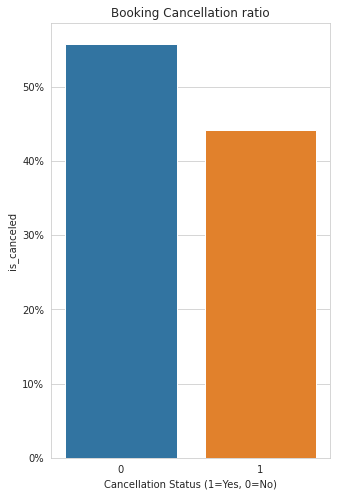

In [19]:
xCancelled, yCancelled = getCount(train_data["is_canceled"])
myPlot(xCancelled, yCancelled, xLable="Cancellation Status (1=Yes, 0=No)", yLable="% Percentage", title="Booking Cancellation ratio",figsize=(5,8),type='bar')

2. Booking cancellation ratio (by hotel type)?

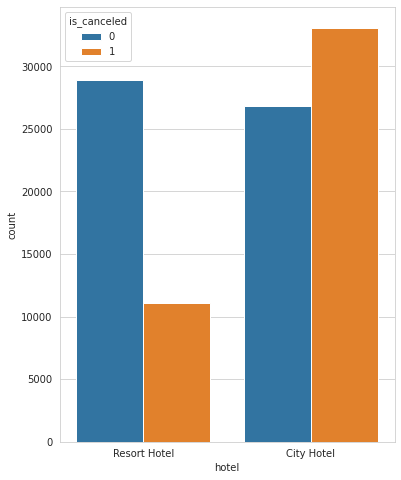

In [20]:
plt.subplots(figsize=(6,8))
sns.countplot(x='hotel',hue='is_canceled',data=train_data)

3. Booking cancellation with respect to the months?

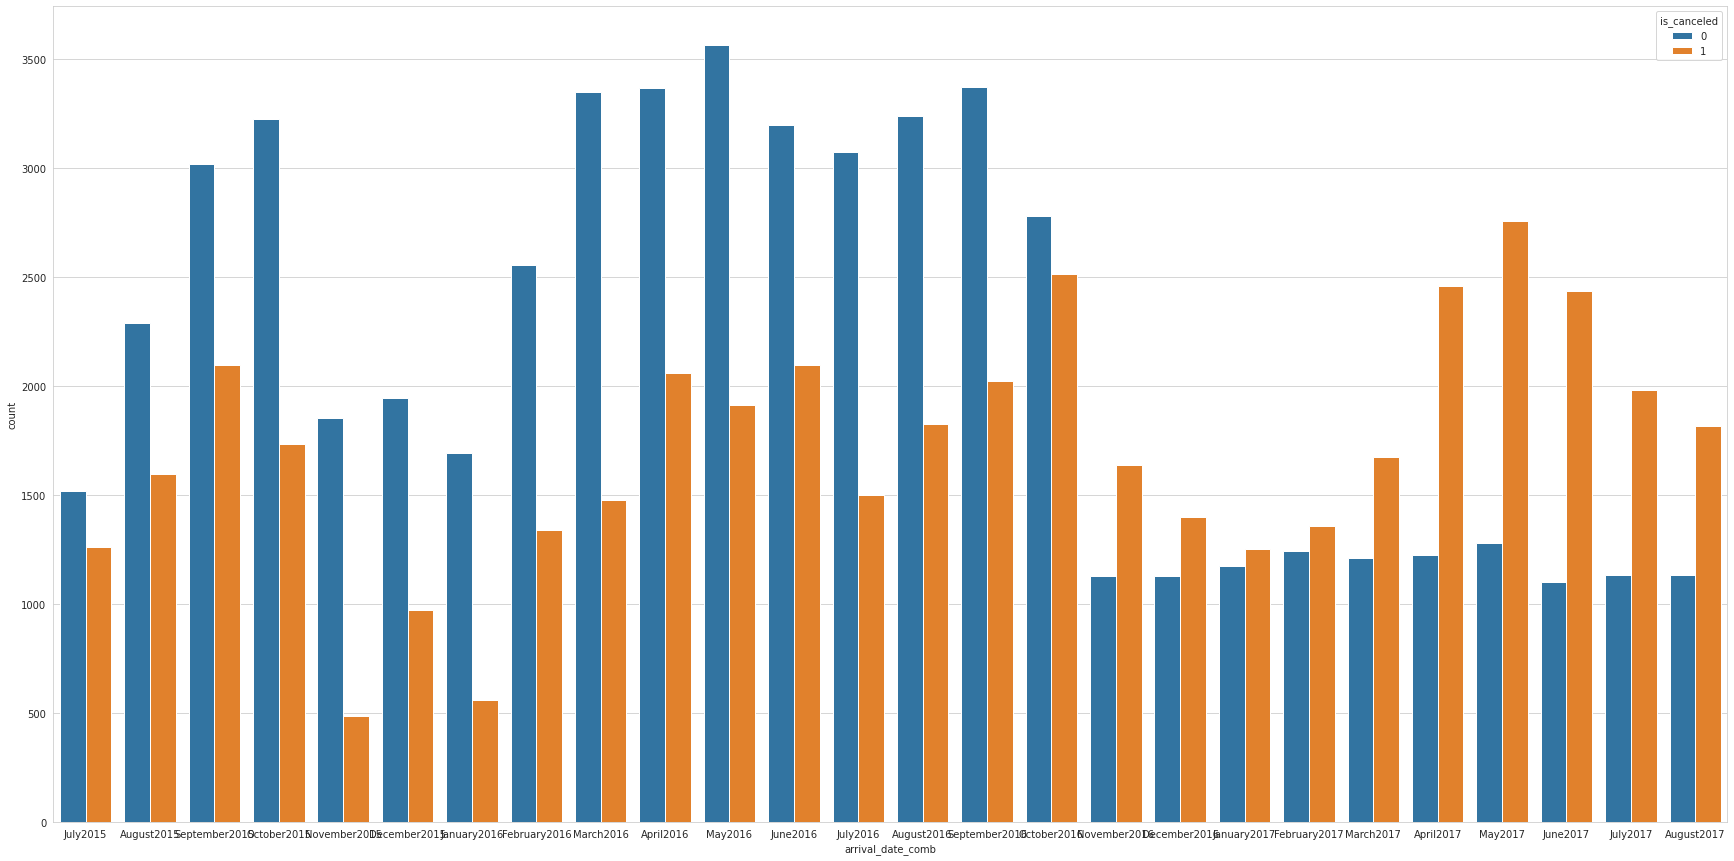

In [21]:
train_new = train_data.copy()
train_new['arrival_date_comb']= train_new['arrival_date_month'] + train_new['arrival_date_year'].astype(str)
train_new['arrival_date_comb']= train_new['arrival_date_month'] + train_new['arrival_date_year'].astype(str)
plt.subplots(figsize=(30,15))
sns.countplot(x='arrival_date_comb',hue='is_canceled',data=train_new)

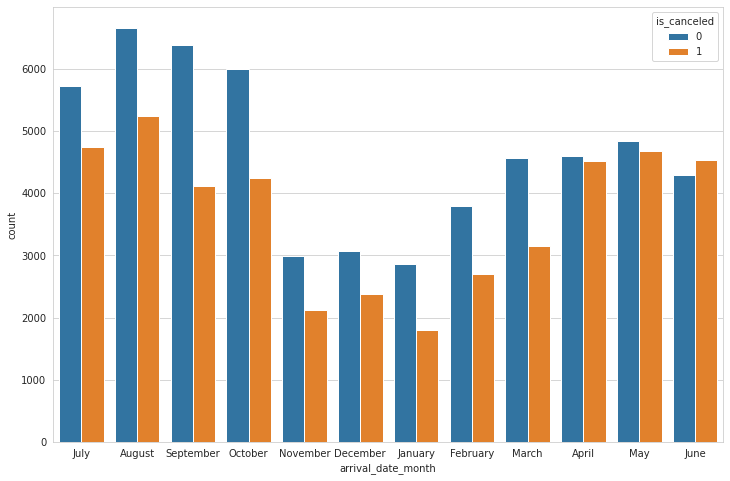

In [22]:
plt.subplots(figsize=(12,8))
sns.countplot(x='arrival_date_month',hue='is_canceled',data=train_data)

In [23]:
train_data['arrival_date'] = train_data['arrival_date_year'].astype(str) + '-' + train_data['arrival_date_month'] + '-' + train_data['arrival_date_day_of_month'].astype(str)
train_data['arrival_date'] = train_data['arrival_date'].apply(pd.to_datetime)
train_data['reservation_status_date'] = train_data['reservation_status_date'].apply(pd.to_datetime)
cancelled_data = train_data[train_data['reservation_status'] == 'Canceled']
cancelled_data['canc_to_arrival_days'] = cancelled_data['arrival_date'] - cancelled_data['reservation_status_date']
cancelled_data['canc_to_arrival_days'] = cancelled_data['canc_to_arrival_days'].dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


4. Cancellations with respect to the Market Segment

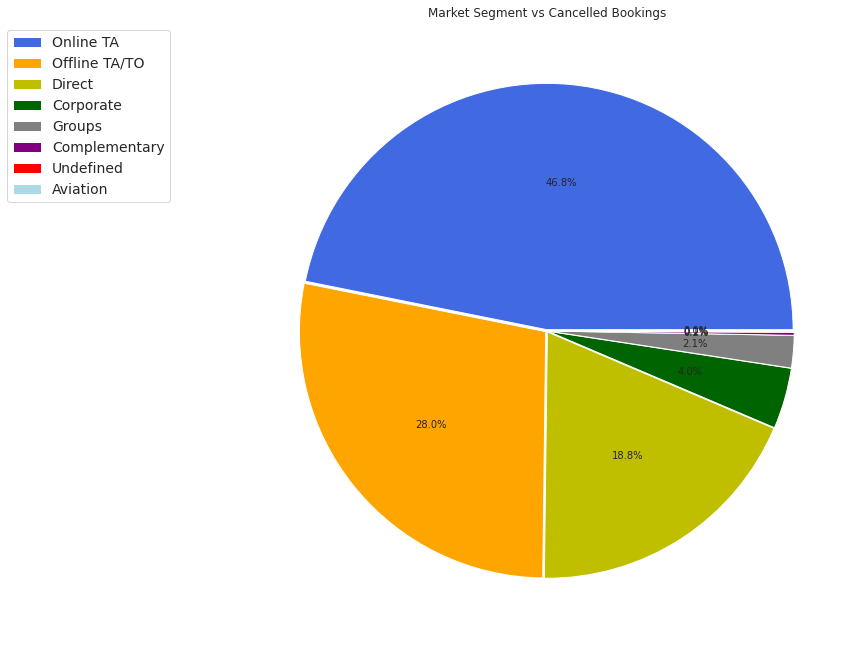

In [24]:
plt.figure(figsize=(12,12))
explode = [0.005] * len(cancelled_data['market_segment'].unique())
colors = ['royalblue','orange','y','darkgreen','gray','purple','red','lightblue']
plt.pie(cancelled_data['market_segment'].value_counts(),
       autopct = '%.1f%%',
       explode = explode,
       colors = colors)
plt.legend(cancelled_data['market_segment'].unique(), bbox_to_anchor=(-0.1, 1.),
           fontsize=14)
plt.title('Market Segment vs Cancelled Bookings')
plt.tight_layout()
plt.show()

5. Cancellation By Customer With Deposit Type.

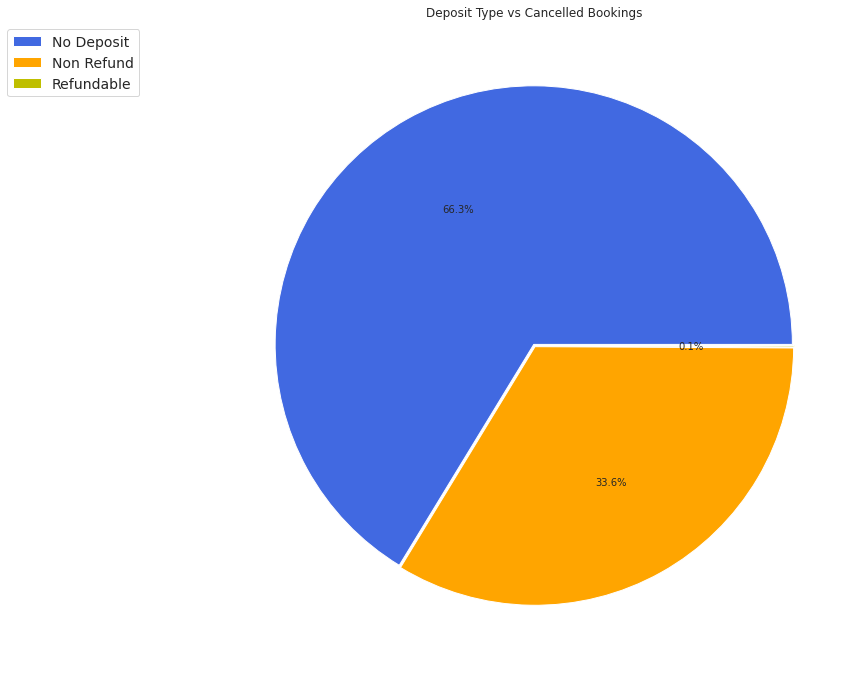

In [25]:
plt.figure(figsize=(12,12))
explode = [0.005] * len(cancelled_data['deposit_type'].unique())
colors = ['royalblue','orange','y','darkgreen','gray','purple','red','lightblue']
plt.pie(cancelled_data['deposit_type'].value_counts(),
       autopct = '%.1f%%',
       explode = explode,
       colors = colors)
plt.legend(cancelled_data['deposit_type'].unique(), bbox_to_anchor=(-0.1, 1.),
           fontsize=14)
plt.title('Deposit Type vs Cancelled Bookings')
plt.tight_layout()
plt.show()

6. Cancelation With Respect To Arrival Date

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


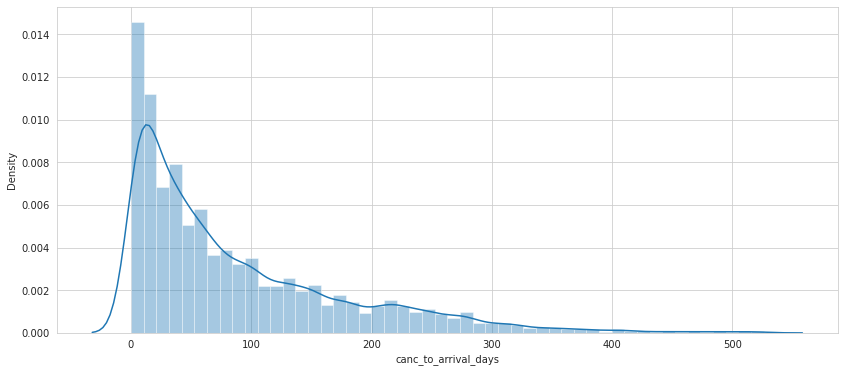

Percentage of cancellations that are within a week of arrival:  11.92 %


In [26]:
plt.figure(figsize=(14,6))
sns.distplot(cancelled_data['canc_to_arrival_days'])
plt.show()

print('Percentage of cancellations that are within a week of arrival: ', 
      (cancelled_data[cancelled_data['canc_to_arrival_days']<=7]['canc_to_arrival_days'].count()*100/cancelled_data['canc_to_arrival_days'].count()).round(2), '%')

# Data Preprocessing

Feature Selection and Feature Engineering

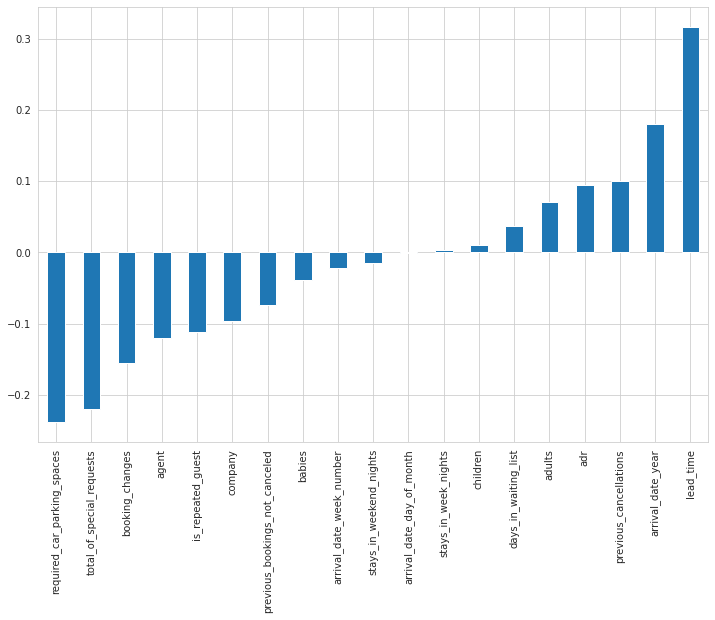

In [28]:
plt.figure(figsize=(12,8))
train_data.corr()['is_canceled'].sort_values()[:-1].plot(kind='bar')
plt.show()

The attributes assigned_room_type and reserved_room_type are important features to consider the cancellation rate, therefore we can combine these two features as a single feature is_assigned_same_room

In [29]:
train_data['is_assigned_same_room'] = 0
train_data.loc[train_data['reserved_room_type']==train_data['assigned_room_type'],'is_assigned_same_room']=1

The attributes previous_cancellations and previous_booking_not_cancelled are important features to consider the cancellation rate, therefore we can combine these two features as a single feature is_cancelled_high

In [30]:
train_data['is_cancelled_high'] = 0
train_data.loc[train_data['previous_cancellations']>train_data['previous_bookings_not_canceled'], 'is_cancelled_high']=1

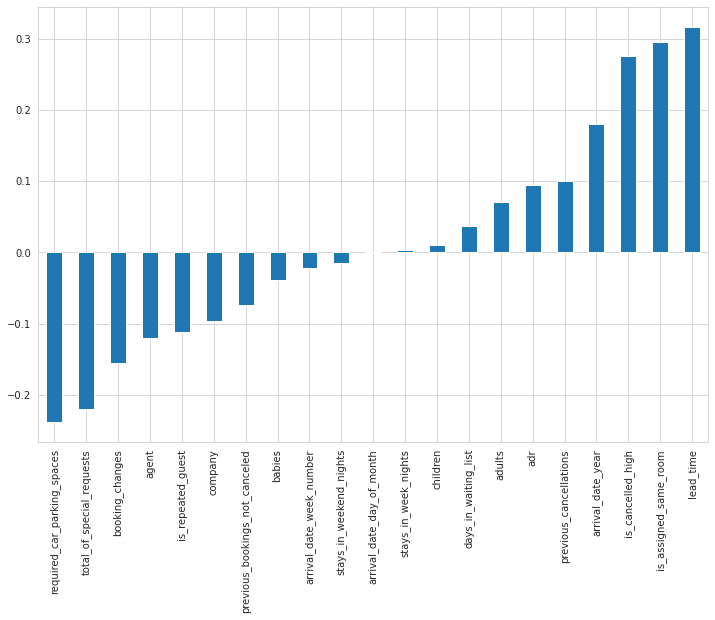

In [31]:
plt.figure(figsize=(12,8))
train_data.corr()['is_canceled'].sort_values()[:-1].plot(kind='bar')
plt.show()

The correlation coefficients of lead_time, is_assigned_same_room, is_cancelled_high is considerably good and have a positive correlation
Hence, this can be made as the primary features
Next, we remove the attributes with less important features bold text

In [32]:
train_data = train_data.drop(['meal','country','reserved_room_type','assigned_room_type','deposit_type','reservation_status','reservation_status_date','arrival_date'], axis=1)

# Transformations

Utility functions

In [33]:
def transform(data):
    
    '''
       Takes in a dataframe as input and returns a new dataframe with the categorical values be label encoded
       
       Input:
           Dataframe
       
       Output:
           Dataframe with encoded categorical values
    '''
    
    from sklearn.preprocessing import LabelEncoder
    
    labelEncoder = LabelEncoder()
    
    categorical_feat = list(data.columns[data.dtypes == object])
    
    print(categorical_feat)
    
    for x in categorical_feat:
        data[x] = labelEncoder.fit_transform(data[x])
    
    return data

In [34]:
train_data = transform(train_data)

['hotel', 'arrival_date_month', 'market_segment', 'distribution_channel', 'customer_type']


In [35]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1001 to 101000
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           100000 non-null  int64  
 1   is_canceled                     100000 non-null  int64  
 2   lead_time                       100000 non-null  int64  
 3   arrival_date_year               100000 non-null  int64  
 4   arrival_date_month              100000 non-null  int64  
 5   arrival_date_week_number        100000 non-null  int64  
 6   arrival_date_day_of_month       100000 non-null  int64  
 7   stays_in_weekend_nights         100000 non-null  int64  
 8   stays_in_week_nights            100000 non-null  int64  
 9   adults                          100000 non-null  int64  
 10  children                        100000 non-null  int64  
 11  babies                          100000 non-null  int64  
 12  market_segmen

In [36]:
train_data = train_data[['is_canceled',
 'hotel',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'is_assigned_same_room',
 'is_cancelled_high']]

## Modelling

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [38]:
model_accuracy_results = {}

Utility Functions

In [39]:
def model_accuracy(y_test, y_pred):
    '''
        Takes in the actual test results and predicted test results and returns the accuracy of the model
        
        Input:
            Actual test results(vector or data frame) and predicted test results(vector or data frame)
            
        Output:
            Accuracy of the model
    '''
    cm = confusion_matrix(y_test, y_pred)
    accuracy = ((cm[0,0] + cm [1,1]) * 100 / len(y_test)).round(2)
    return accuracy

In [ ]:
def get_confustion_matrix(y_test, y_pred):
    '''
        Takes in the actual test results and predicted test results and returns the confusion matrix
        
        Input:
            Actual test results(vector or data frame) and predicted test results(vector or data frame)
            
        Output:
            Confusion matrix
    '''
    cm = confusion_matrix(y_test, y_pred)
    return cm

In [40]:
def train(x_train,y_train,x_test,y_test,model):
    '''
        Takes in the training and testing datasets with dependent and independant variables along with the model name
        ('svm','randomforest') as input
        
        Then fit, train and returns the model as the output
        
        Input:
            X_train, y_train, X_test, y_test and model name ('svm','randomforest')
        
        Ouptut:
            Trained Model
    
    '''
    
    if(model=='svm'):
        from sklearn.svm import SVC
        classifier = SVC(kernel = 'rbf', random_state=0)
        classifier.fit(x_train,y_train)

        y_pred = classifier.predict(x_test)

        model_accuracy_results['SVM'] = model_accuracy(y_test, y_pred)
        return classifier
    if(model=='randomforest'):
        from sklearn.ensemble import RandomForestClassifier
        classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
        classifier.fit(x_train,y_train)

        y_pred = classifier.predict(x_test)

        model_accuracy_results['RandomForest'] = model_accuracy(y_test, y_pred)
        return classifier

In [41]:
scaler = StandardScaler()

For the Modelling, First we split our data.

1. Test Train Split

In [42]:
X = train_data.iloc[:, 1:].values
y = train_data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

2. Standardization

In [43]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

3. Model Training

In [44]:
svm_test = train(X_train,y_train,X_test,y_test,'svm')
random_forest_test = train(X_train,y_train,X_test,y_test,'randomforest')

4. Accuracy Test

In [ ]:
df_model_accuracies = pd.DataFrame(list(model_accuracy_results.values()), index=model_accuracy_results.keys(), columns=['Accuracy'])
df_model_accuracies

,Accuracy
SVM,86.07
RandomForest,90.57


In [ ]:
f1_score(y_test, random_forest_test.predict(X_test))

0.8910955108073157

In [ ]:
roc_auc_score(y_test, random_forest_test.predict(X_test))

0.901386243324927

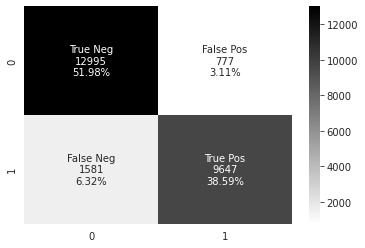

In [ ]:
orf_cm = confusion_matrix(y_test, random_forest_test.predict(X_test))

names = ['True Neg','False Pos','False Neg','True Pos'] 
values = [value for value in orf_cm.flatten()] 
percentages = [str(perc.round(2))+'%' for perc in orf_cm.flatten()*100/np.sum(orf_cm)] 
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names,values,percentages)] 
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(orf_cm, annot=labels, fmt='', cmap='binary')

Random Forests comes out on top so we tuned it Further

However, there are more false negatives as seen in the confusion matrix, hence we enhanced the random forest with some optimizations

In [45]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
model = RandomForestClassifier()
rfecv = RFECV(estimator=RandomForestClassifier())
pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=36851234)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)
#grid_search = GridSearchCV(estimator = randomforestclassifier,
 #                          param_grid = parameter , 
  #                         cv=5,
   #                        scoring = 'accuracy',
    #                       n_jobs = -1)
pipeline.fit(X_train, y_train)
#print(“Optimal number of features : %d” % rfecv.n_features_)

Pipeline(steps=[('Feature Selection',
                 RFECV(estimator=RandomForestClassifier())),
                ('Model', RandomForestClassifier())])

In [63]:
#print('Best Score: ', grid_search.best_score_.round(2))
#print('Best Parameters: ', grid_search.best_params_)
from numpy import mean
from numpy import std
print("Optimal number of features : %d" % rfecv.n_features_)
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Optimal number of features : 26
Accuracy: 0.906 (0.003)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


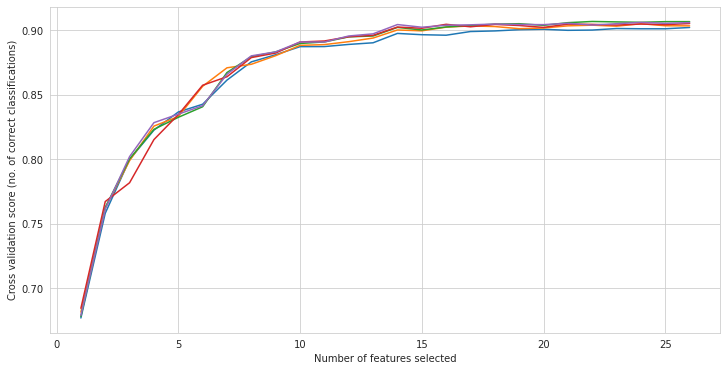

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (no. of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [62]:
pipeline.show()

AttributeError: ignored

We used the above best parameters to retrain our model

In [ ]:
random_forest_optimized_test = RandomForestClassifier(n_estimators=500, max_features=10, criterion='entropy', random_state=21)
random_forest_optimized_test.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_features=10, n_estimators=500,
                       random_state=21)

In [ ]:
y_pred = random_forest_optimized_test.predict(X_test)
model_accuracy_results['OptimizedRandomForest'] = model_accuracy(y_test, y_pred)

In [ ]:
df_model_accuracies = pd.DataFrame(list(model_accuracy_results.values()), index=model_accuracy_results.keys(), columns=['Accuracy'])
df_model_accuracies

,Accuracy
SVM,86.07
RandomForest,90.57
OptimizedRandomForest,90.64


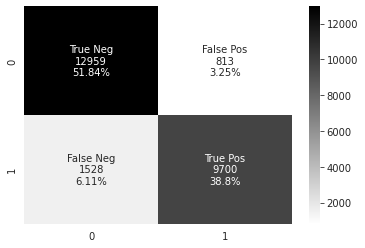

In [ ]:
orf_cm = confusion_matrix(y_test, random_forest_optimized_test.predict(X_test))

names = ['True Neg','False Pos','False Neg','True Pos'] 
values = [value for value in orf_cm.flatten()] 
percentages = [str(perc.round(2))+'%' for perc in orf_cm.flatten()*100/np.sum(orf_cm)] 
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names,values,percentages)] 
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(orf_cm, annot=labels, fmt='', cmap='binary')

In [ ]:
f1_score(y_test, random_forest_optimized_test.predict(X_test))
roc_auc_score(y_test, random_forest_optimized_test.predict(X_test))

0.9024394146164402

## Final Model Creation

Utility Functions

In [ ]:
def train_model(train_df):
    
    #data cleaning
    train_df['company'].fillna(0, inplace=True)
    train_df['agent'].fillna(0, inplace=True)
    train_df['country'].fillna(train_df.country.mode().to_string(), inplace=True)
    train_df['children'].fillna(train_df.children.mean(), inplace=True)
    
    #data type conversion
    train_df[['children', 'company', 'agent']] = train_df[['children', 'company', 'agent']].astype('int64')
    
    #data transoformation
    train_df['is_assigned_same_room'] = 0
    train_df.loc[train_df['reserved_room_type']==train_df['assigned_room_type'],'is_assigned_same_room']=1
    
    train_df['is_cancelled_high'] = 0
    train_df.loc[train_df['previous_cancellations']>train_df['previous_bookings_not_canceled'], 'is_cancelled_high']=1
    
    train_df = train_df[['is_canceled',
                             'hotel',
                             'lead_time',
                             'arrival_date_year',
                             'arrival_date_month',
                             'arrival_date_week_number',
                             'arrival_date_day_of_month',
                             'stays_in_weekend_nights',
                             'stays_in_week_nights',
                             'adults',
                             'children',
                             'babies',
                             'market_segment',
                             'distribution_channel',
                             'is_repeated_guest',
                             'previous_cancellations',
                             'previous_bookings_not_canceled',
                             'booking_changes',
                             'agent',
                             'company',
                             'days_in_waiting_list',
                             'customer_type',
                             'adr',
                             'required_car_parking_spaces',
                             'total_of_special_requests',
                            'is_assigned_same_room',
                            'is_cancelled_high']]
    train_df = transform(train_df)
    X_train = train_df.iloc[:, 1:].values
    y_train = train_data.iloc[:, 0].values
    X_train = scaler.fit_transform(X_train)
    model = RandomForestClassifier(n_estimators=500, max_features=10, criterion='entropy', random_state=0)
    model.fit(X_train,y_train)
    return model

In [ ]:
def transform_test(test_df):
    #data cleaning
    test_df['company'].fillna(0, inplace=True)
    test_df['agent'].fillna(0, inplace=True)
    test_df['country'].fillna(test_df.country.mode().to_string(), inplace=True)
    test_df['children'].fillna(test_df.children.mean(), inplace=True)
    
    #data type conversion
    test_df[['children', 'company', 'agent']] = test_df[['children', 'company', 'agent']].astype('int64')
    
    #data transoformation
    test_df['is_assigned_same_room'] = 0
    test_df.loc[test_df['reserved_room_type']==test_df['assigned_room_type'],'is_assigned_same_room']=1
    
    test_df['is_cancelled_high'] = 0
    test_df.loc[test_df['previous_cancellations']>test_df['previous_bookings_not_canceled'], 'is_cancelled_high']=1
    
    test_df = test_df[[      'hotel',
                             'lead_time',
                             'arrival_date_year',
                             'arrival_date_month',
                             'arrival_date_week_number',
                             'arrival_date_day_of_month',
                             'stays_in_weekend_nights',
                             'stays_in_week_nights',
                             'adults',
                             'children',
                             'babies',
                             'market_segment',
                             'distribution_channel',
                             'is_repeated_guest',
                             'previous_cancellations',
                             'previous_bookings_not_canceled',
                             'booking_changes',
                             'agent',
                             'company',
                             'days_in_waiting_list',
                             'customer_type',
                             'adr',
                             'required_car_parking_spaces',
                             'total_of_special_requests',
                            'is_assigned_same_room',
                            'is_cancelled_high']]
    test_df = transform(test_df)
    test_df = test_df.iloc[:,:].values
    test_df = scaler.fit_transform(test_df)
    return test_df

Loading Files and Training

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/train.csv',index_col=0)

In [ ]:
model = train_model(train_df)

['hotel', 'arrival_date_month', 'market_segment', 'distribution_channel', 'customer_type']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv',index_col=0)

In [ ]:
test_df = transform_test(test_df)

['hotel', 'arrival_date_month', 'market_segment', 'distribution_channel', 'customer_type']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
pred_res = model.predict(test_df)

In [ ]:
pred_res

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/submission.csv')

In [ ]:
submission['is_canceled'] = pred_res

In [ ]:
submission.to_csv('submission.csv',index=False)

In [ ]:
X

array([[1.000e+00, 3.420e+02, 2.015e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.000e+00, 7.370e+02, 2.015e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.000e+00, 7.000e+00, 2.015e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [0.000e+00, 2.560e+02, 2.016e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [0.000e+00, 2.560e+02, 2.016e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [0.000e+00, 2.560e+02, 2.016e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

## Creating A pickle file for exporting the model

In [ ]:
#importing the pickle library which is a part of pythons in built packages
import pickle
# save the model to disk
model_pkl = 'Final Random Forest Model.pkl'

with open(model_pkl, 'wb') as file:
  pickle.dump(model, file)